# Similarity Score Threshold Calculator

Calculates the average threshoold between the original query and ChatGPT-generated similar queries.<br>
The first query in the df is the original query.

### Import relevant package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import spacy
import pandas as pd
from math import sqrt
!python -m spacy download en_core_web_md
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 27.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 3.3 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Import dataset

In [ ]:
file_path = 'drive/MyDrive/BT4103 Capstone Project/Database/Similar_queries.csv'
df = pd.read_csv(file_path)
df.head()

,Question,Score
0,"If I am starting a business, what are the key ...",1.000
1,"If I start a company, what are the critical th...",0.977
2,"If I start a business, what are the important ...",0.929
3,What should I consider when planning to start ...,0.928
4,What key elements should I consider when start...,0.925


### Create embeddings

In [ ]:
nlp = spacy.load('en_core_web_md')
sentences = df['Question'].to_list()
sentences = [sent.lower() for sent in sentences]
model1 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model2 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

### Embbed sentences and check time (model1)

In [ ]:
import time
time_start = time.time()
# embeddings = [nlp(sentence).vector for sentence in sentences]
embeddings = [model1.encode(sentence) for sentence in sentences ]
time_end = time.time()
runtime = time_end - time_start


original_query = df.iloc[0]['Question']
query_embedding = embeddings[0]
similar_query_embedding = embeddings

print("--- %s seconds ---" % (runtime))
print(f"Number of queries: {len(sentences)}")
print(f"Average runtime per query (sec): {runtime / len(sentences)}")

--- 1.6932799816131592 seconds ---
Number of queries: 96
Average runtime per query (sec): 0.01763833314180374


### Embbed sentences and check time (model2)

In [ ]:
import time
time_start = time.time()
embeddings = [model2.encode(sentence) for sentence in sentences ]
time_end = time.time()
runtime = time_end - time_start

original_query = df.iloc[0]['Question']
query_embedding = embeddings[0]
similar_query_embedding = embeddings

print("--- %s seconds ---" % (runtime))
print(f"Number of queries: {len(sentences)}")
print(f"Average runtime per query (sec): {runtime / len(sentences)}")

--- 13.561685562133789 seconds ---
Number of queries: 96
Average runtime per query (sec): 0.14126755793889365


### Calculate similarity score for each query

In [ ]:
def squared_sum(x):
  # Calculate 3 rounded square rooted value
  return round(sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  # Calculate cosine similarity between two lists
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

score_list = []
for idx in range(len(similar_query_embedding)):
    curr_embedding = similar_query_embedding[idx]
    score = cos_similarity(query_embedding, curr_embedding)
    score_list.append(score)

df['Score'] = score_list
df_test = df.iloc[1:]
avg_score = round(df_test['Score'].mean(), 3)
print(f"Average similarity score: {avg_score}")
df_test.head()

Average similarity score: 0.858


,Question,Score
1,"If I start a company, what are the critical th...",0.780
2,"If I start a business, what are the important ...",0.820
3,What should I consider when planning to start ...,0.828
4,What key elements should I consider when start...,0.890
5,What factors should I weigh when starting a bu...,0.839


### Evaluate scores

In [ ]:
# Number of queries above average similarity score
df_pass = df_test[df_test['Score'] >= avg_score]
print(f"Number of similar queries above avg similarity score: {df_pass.shape[0]}")

Number of similar queries above avg similarity score: 50


In [ ]:
# Query with highest similrity score
row_highest = df_test[df_test.Score == df_test.Score.max()].iloc[0]
print("Highest matching query")
print(f"Similarity score: {row_highest['Score']}")
print(f"Original query: {original_query}")
print(f"Similar query: {row_highest['Question']}")

Highest matching query
Similarity score: 0.963
Original query: If I am starting a business, what are the key factors I need to consider?
Similar query: What are the key factors to consider when starting a business?


In [ ]:
# Query with lowest similrity score
row_lowest = df_test[df_test.Score == df_test.Score.min()].iloc[0]
print("Lowest matching query")
print(f"Similarity score: {row_lowest['Score']}")
print(f"Original query: {original_query}")
print(f"Similar query: {row_lowest['Question']}")

Lowest matching query
Similarity score: 0.729
Original query: If I am starting a business, what are the key factors I need to consider?
Similar query: What should I think about before starting a business?


### Save df to csv

In [ ]:
df = df.sort_values(by='Score', ascending = False)
df.to_csv(file_path, index = False)

# Optimal Threshold using PAWS

In [ ]:
!pip install datasets
!pip install matplotlib

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import numpy as np

ds = load_dataset("AlekseyKorshuk/quora-question-pairs")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/41.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'],
        num_rows: 404290
    })
})

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(ds['train'])
df = df.rename(columns={'question1': 'sentence1', 'question2': 'sentence2', 'is_duplicate': 'label'})
df1 = df[3000:6000]
df1

,id,qid1,qid2,sentence1,sentence2,label
3000,3000,5949,5950,What song can you listen to and never get tire...,What songs can you listen to over and over and...,1
3001,3001,5951,5952,How are the British troops stationed in Bermud...,How would a modern day Falklands war turn out?,0
3002,3002,5953,5954,How long can someone live with cancer and with...,How far could someone go if they could live wi...,0
3003,3003,5955,5956,What type of diets can you follow to lose 5 po...,How can I lose 5lbs in 2 weeks?,1
3004,3004,5957,5958,Which is the best commerce college in Mangalore?,Which is the best commerce college in Kolkata?,0
...,...,...,...,...,...,...
5995,5995,6468,11761,Who will win IPL 2016?,Which team win IPL 9?,1
5996,5996,11762,11763,Which is stronger titanium or diamonds?,What is titanium?,0
5997,5997,11764,11765,How much data does Skype use per minute?,How much data does a 20 minute Skype call use?,0
5998,5998,11766,11767,How can I meet Narendra Modi?,How can I meet Sir Narendra Modi Ji?,1


In [ ]:
binary_counts = df1['label'].value_counts()

Text(0, 0.5, 'Frequency')

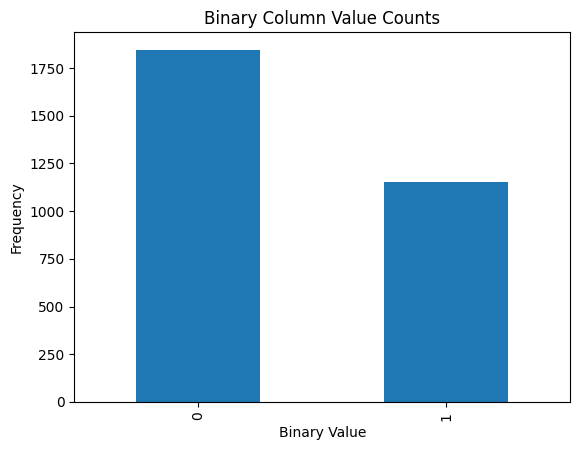

In [ ]:
# 2. Plot the bar chart
binary_counts.plot(kind='bar')

# 3. Add labels and title
plt.title('Binary Column Value Counts')
plt.xlabel('Binary Value')
plt.ylabel('Frequency')

In [ ]:
model1 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model2 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
df1['s1'] = df1['sentence1'].str.lower()
df1['s2'] = df1['sentence2'].str.lower()

<ipython-input-41-80ed2bbb025a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['s1'] = df1['sentence1'].str.lower()
<ipython-input-41-80ed2bbb025a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['s2'] = df1['sentence2'].str.lower()


### Embed using model1

In [ ]:
import time
time_start = time.time()

s1_list = df1['s1'].to_list()
s1_embeddings = [model2.encode(x) for x in s1_list]

time_end = time.time()
runtime = time_end - time_start

s2_list = df1['s2'].to_list()
s2_embeddings = [model2.encode(x) for x in s2_list]


print(f"Number of queries: {df1.shape[0]}")
print(f"Total runtime (sec): {runtime}")
print(f"Average runtime per query (sec): {runtime / df1.shape[0]}")

Number of queries: 3000
Total runtime (sec): 387.2614715099335
Average runtime per query (sec): 0.12908715716997782


### Embed using model2

In [ ]:
# import time
# time_start = time.time()

# s1_list = df1['s1'].to_list()
# s1_embeddings = [model2.encode(x) for x in s1_list]

# time_end = time.time()
# runtime = time_end - time_start

# s2_list = df1['s2'].to_list()
# s2_embeddings = [model2.encode(x) for x in s2_list]


# print(f"Number of queries: {df1.shape[0]}")
# print(f"Total runtime (sec): {runtime}")
# print(f"Average runtime per query (sec): {runtime / df1.shape[0]}")

In [ ]:
df1.head()

,id,qid1,qid2,sentence1,sentence2,label,s1,s2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?


In [ ]:
df1['s1_embedding'] = s1_embeddings
df1['s2_embedding'] = s2_embeddings

<ipython-input-43-95a8b0f7313f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['s1_embedding'] = s1_embeddings
<ipython-input-43-95a8b0f7313f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['s2_embedding'] = s2_embeddings


In [ ]:
df1.head()

,id,qid1,qid2,sentence1,sentence2,label,s1,s2,s1_embedding,s2_embedding,similarity_score
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,"[0.014816565, -0.06528712, -0.03090181, -0.088...","[-0.0030336704, -0.09681215, -0.017740047, -0....",0.912
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,"[0.02725333, 0.007704069, -0.0077243256, 0.053...","[0.027895978, 0.095231615, 0.001280422, 0.0686...",0.655
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,"[-0.013890668, 0.023525324, -0.037284587, 0.05...","[0.008544574, 0.028912243, -0.053461883, 0.053...",0.516
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,"[0.03645535, -0.014002155, 0.005363633, -0.007...","[0.03646099, -0.06334951, 0.009014454, -0.0265...",0.104
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,"[0.055337775, -0.08990559, -0.009859435, -0.07...","[0.0074477512, -0.09320646, -0.049515918, -0.0...",0.325


In [ ]:
def squared_sum(x):
  # Calculate 3 rounded square rooted value
  return round(sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  # Calculate cosine similarity between two lists
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [ ]:
score_list = []
for idx in range(len(s1_embeddings)):
    s1_vec = s1_embeddings[idx]
    s2_vec = s2_embeddings[idx]
    score = cos_similarity(s1_vec, s2_vec)
    score_list.append(score)

In [ ]:
df1['similarity_score'] = score_list

<ipython-input-45-c546d61072c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['similarity_score'] = score_list


In [ ]:
df1.to_csv('drive/MyDrive/BT4103 Capstone Project/Database/quora_model2_3000_6000.csv', index=False)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc

In [ ]:
# df1 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/similarity_score_0_500.csv')
# df2 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/similarity_score_500_1000.csv')
# df3 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/similarity_score_1000_2000.csv')
# df4 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/similarity_score_2000_3000.csv')
df1 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/quora_model1_3000_6000.csv')
df2 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/quora_model1_0_3000.csv')
# df3 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/quora_similarity_score_2000_3000.csv')
# df4 = pd.read_csv('drive/MyDrive/BT4103 Capstone Project/Database/quora_similarity_score_3000_6000.csv')

combined_df = pd.concat([df2, df1], axis=0)



In [ ]:
l1_df = combined_df[combined_df['label'] == 1]
l0_df = combined_df[combined_df['label'] == 0]

print(len(l1_df))
print(len(l0_df))

2290
3710


In [ ]:
combined_df = pd.concat([l1_df, l0_df[:742]], axis=0)

In [ ]:
true_labels = combined_df['label'].to_list()
score_list = combined_df['similarity_score'].to_list()

ROC AUC Score: 0.8703


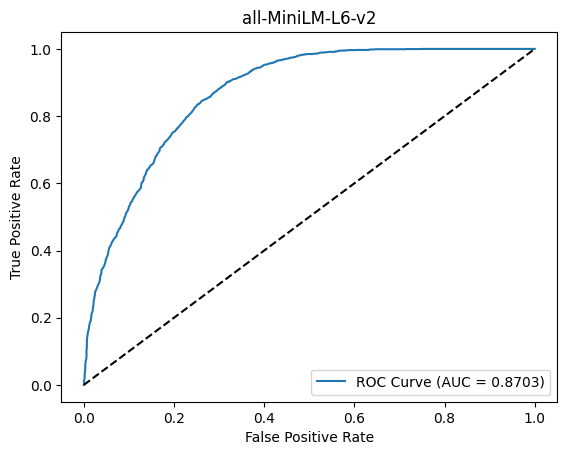

In [ ]:
roc_auc = roc_auc_score(true_labels, score_list)
print(f"ROC AUC Score: {roc_auc:.4f}")

# 4. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, score_list)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('all-MiniLM-L6-v2')
plt.legend(loc='best')
plt.show()

In [ ]:
youden_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_index]
print(f'Optimal Threshold (Youden\'s J): {optimal_threshold}')
print(f'FPR at Youden\'s J: {fpr[youden_index]}')
print(f'TPR at Youden\'s J: {tpr[youden_index]}')
print(f'Max TPR-FPR: {tpr[youden_index] - fpr[youden_index]}')

Optimal Threshold (Youden's J): 0.73
FPR at Youden's J: 0.316711590296496
TPR at Youden's J: 0.9004366812227074
Max TPR-FPR: 0.5837250909262114


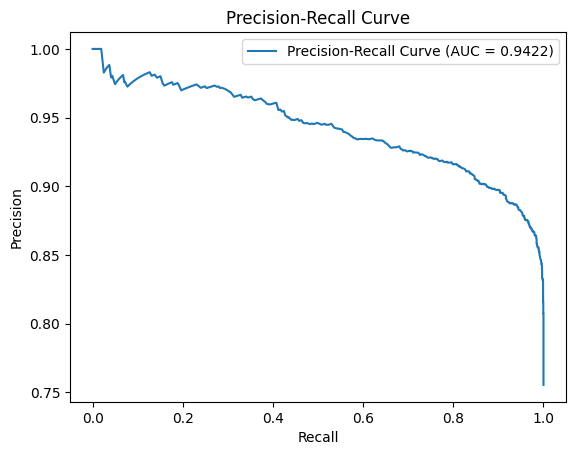

In [ ]:
precision, recall, _ = precision_recall_curve(true_labels, score_list)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

### Compare models

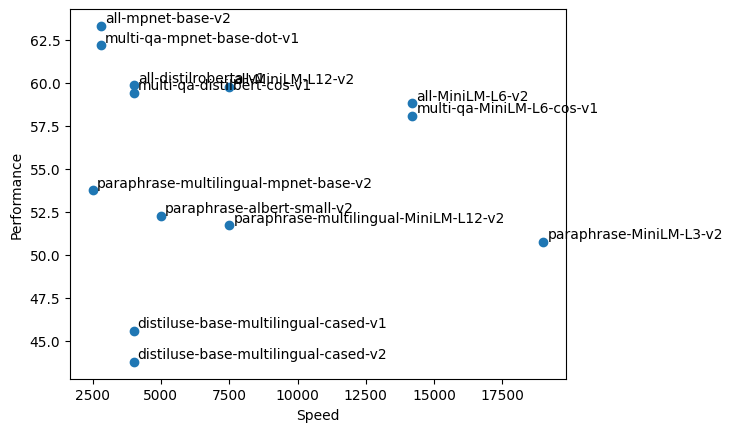

In [ ]:
model_list = ['all-mpnet-base-v2', 'multi-qa-mpnet-base-dot-v1', 'all-distilroberta-v1', 'all-MiniLM-L12-v2', 'multi-qa-distilbert-cos-v1', 'all-MiniLM-L6-v2',
              'multi-qa-MiniLM-L6-cos-v1', 'paraphrase-multilingual-mpnet-base-v2', 'paraphrase-albert-small-v2', 'paraphrase-multilingual-MiniLM-L12-v2',
              'paraphrase-MiniLM-L3-v2', 'distiluse-base-multilingual-cased-v1', 'distiluse-base-multilingual-cased-v2']
perf_list = [63.3, 62.18, 59.84, 59.76, 59.41, 58.8, 58.08, 53.75, 52.25, 51.72, 50.74, 45.59, 43.77]
speed_list = [2800, 2800, 4000, 7500, 4000, 14200, 14200, 2500, 5000, 7500, 19000, 4000, 4000]
df_perf = pd.DataFrame({'model': model_list, 'performance': perf_list, 'speed': speed_list})

fig, ax = plt.subplots()
ax.scatter(x=df_perf['speed'], y = df_perf['performance'])
ax.set_xlabel('Speed')
ax.set_ylabel('Performance')
for i, txt in enumerate(model_list):
    ax.annotate(txt, (speed_list[i] + 150, perf_list[i] + 0.2))